# Marketing analysis



## Table of Contents
- [Introduction](#intro)
- [Data wrangling](#data_wrangling)
- [Part I: Channels overview](#channels_overview)
- [Part II: TV spending impact](#tv_spending)
- [Part III: Budget allocation](#budget_allocation)
- [Conclusions](#conclusions)

<a id='intro'></a>
### Introduction

##### Marketing Analysis Task
The analysis will cover the following topics:
* Part I: Overview of the channels and how they contribute to user acquisition
* Part II: Estimating the impact of doubling TV spending
* Part III: Assumptions for the channel touchpoint cost and recommendations on how to change the budget allocation to maximize user acquisition with a constant budget

##### Data
`tv_campaigns.csv`
- a csv with dates on which heavy TV spend was active (assume equal spend on each day)

`user_signup_data.csv`
- a csv with the userid, signup date & binary variables indicating whether
  the user interacted with a given marketing channel prior to signup


<a id='data_wrangling'></a>
### Data wrangling

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

In [2]:
# Create a dataframe from the user_signup_data.csv file and check the first 5 rows
df_user = pd.read_csv('user_signup_data.csv')
df_user.head()

,userid,cpc,organic,affiliate,social,signup_date
0,e0912256-b48a-45c0-afec-23350d341abd,1,0,0,1,2017-02-01
1,321c18f1-c58e-488d-a60a-462dfc9d38aa,1,0,1,0,2017-01-10
2,3d03c163-d14b-49da-873a-a54cc3b400e3,0,0,1,1,2017-03-24
3,3acb5a84-4375-405b-9a8b-bfb8979ab9bc,1,0,0,0,2017-03-06
4,1b488764-6874-4483-8e70-815feb07b154,1,0,0,0,2017-03-03


In [3]:
# Check the quality of data, if there are null entires
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
userid         5000 non-null object
cpc            5000 non-null int64
organic        5000 non-null int64
affiliate      5000 non-null int64
social         5000 non-null int64
signup_date    5000 non-null object
dtypes: int64(4), object(2)
memory usage: 234.5+ KB


In [4]:
# Check the data types
df_user.dtypes

userid         object
cpc             int64
organic         int64
affiliate       int64
social          int64
signup_date    object
dtype: object

In [5]:
# Create a dataframe from the tv_campaigns.csv file 
df_camp = pd.read_csv('tv_campaigns.csv')
df_camp.head(10)

,date,campaign
0,2017-01-24,tv campaign
1,2017-02-26,tv campaign
2,2017-03-26,tv campaign
3,2017-03-05,tv campaign
4,2017-03-14,tv campaign
5,2017-01-01,tv campaign
6,2017-02-08,tv campaign
7,2017-02-09,tv campaign


In [6]:
# Create a new dataframe based on the previous two, joined by signup_date and date
df = df_user.merge(df_camp, how = 'left', left_on = 'signup_date', right_on = 'date').\
   drop(columns = ['date'])
df.head()

,userid,cpc,organic,affiliate,social,signup_date,campaign
0,e0912256-b48a-45c0-afec-23350d341abd,1,0,0,1,2017-02-01,NaN
1,321c18f1-c58e-488d-a60a-462dfc9d38aa,1,0,1,0,2017-01-10,NaN
2,3d03c163-d14b-49da-873a-a54cc3b400e3,0,0,1,1,2017-03-24,NaN
3,3acb5a84-4375-405b-9a8b-bfb8979ab9bc,1,0,0,0,2017-03-06,NaN
4,1b488764-6874-4483-8e70-815feb07b154,1,0,0,0,2017-03-03,NaN


In [7]:
# Replace in column campaign null values with 0 and 'tv campaign' with 1
df['is_tv_campaign'] = (df['campaign'] == 'tv campaign').astype('int')
df = df.replace(np.nan, 'no tv campaign', regex=True)
df.head()

,userid,cpc,organic,affiliate,social,signup_date,campaign,is_tv_campaign
0,e0912256-b48a-45c0-afec-23350d341abd,1,0,0,1,2017-02-01,no tv campaign,0
1,321c18f1-c58e-488d-a60a-462dfc9d38aa,1,0,1,0,2017-01-10,no tv campaign,0
2,3d03c163-d14b-49da-873a-a54cc3b400e3,0,0,1,1,2017-03-24,no tv campaign,0
3,3acb5a84-4375-405b-9a8b-bfb8979ab9bc,1,0,0,0,2017-03-06,no tv campaign,0
4,1b488764-6874-4483-8e70-815feb07b154,1,0,0,0,2017-03-03,no tv campaign,0


In [8]:
# Convert signup_date to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 8 columns):
userid            5000 non-null object
cpc               5000 non-null int64
organic           5000 non-null int64
affiliate         5000 non-null int64
social            5000 non-null int64
signup_date       5000 non-null datetime64[ns]
campaign          5000 non-null object
is_tv_campaign    5000 non-null int64
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 351.6+ KB


In [9]:
#Check if there are correlations
df.corr()

,cpc,organic,affiliate,social,is_tv_campaign
cpc,1.000000,-0.001533,-0.567837,-0.175666,0.011704
organic,-0.001533,1.000000,-0.378763,-0.094708,0.004003
affiliate,-0.567837,-0.378763,1.000000,-0.011317,-0.011824
social,-0.175666,-0.094708,-0.011317,1.000000,-0.006972
is_tv_campaign,0.011704,0.004003,-0.011824,-0.006972,1.000000


<a id='channels_overview'></a>
### Part I: Channels overview
Overview of the channels and how they contribute to user acquisition.

In [10]:
# Calculate percentage of users that visited each channel
df[['cpc','organic','affiliate','social']].mean().sort_values(ascending=False)

affiliate    0.7794
social       0.5970
cpc          0.3316
organic      0.1038
dtype: float64

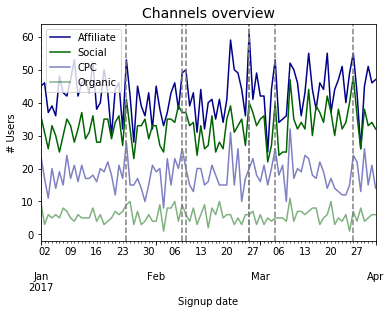

In [11]:
# Visualize nr of users over time for each channel including the campaign dates marked
df.groupby(['signup_date']).sum().affiliate.plot(kind='line',label = 'Affiliate', color = 'darkblue', alpha = 1)
df.groupby(['signup_date']).sum().social.plot(kind='line',label = 'Social', color = 'darkgreen', alpha = 1)
df.groupby(['signup_date']).sum().cpc.plot(kind='line',label = 'CPC', color = 'darkblue', alpha = .5)
df.groupby(['signup_date']).sum().organic.plot(kind='line',label = 'Organic', color = 'darkgreen', alpha = .5)
plt.legend()
plt.title("Channels overview",fontsize=14)
plt.xlabel('Signup date', fontsize=10)
plt.ylabel('# Users', fontsize=10)
plt.axvline(x='2017-01-24', color = 'gray',linestyle='--')
plt.axvline(x='2017-02-26', color = 'gray',linestyle='--')
plt.axvline(x='2017-03-26', color = 'gray',linestyle='--')
plt.axvline(x='2017-03-05', color = 'gray',linestyle='--')
plt.axvline(x='2017-01-01', color = 'gray',linestyle='--')
plt.axvline(x='2017-02-26', color = 'gray',linestyle='--')
plt.axvline(x='2017-02-08', color = 'gray',linestyle='--')
plt.axvline(x='2017-02-09', color = 'gray',linestyle='--');


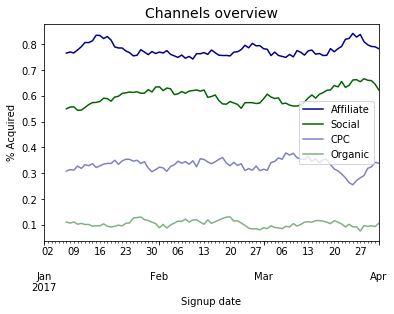

In [12]:
# Normalize the data with a 7 days moving averge to see better see the trend line
df.groupby(['signup_date']).mean().affiliate.rolling(window=7).mean().plot(kind='line',label = 'Affiliate',color = 'darkblue', alpha = 1)
df.groupby(['signup_date']).mean().social.rolling(window=7).mean().plot(kind='line',label = 'Social',color = 'darkgreen', alpha = 1)
df.groupby(['signup_date']).mean().cpc.rolling(window=7).mean().plot(kind='line',label = 'CPC',color = 'darkblue', alpha = .5)
df.groupby(['signup_date']).mean().organic.rolling(window=7).mean().plot(kind='line',label = 'Organic',color = 'darkgreen', alpha = .5)
plt.legend()
plt.title("Channels overview",fontsize=14)
plt.xlabel('Signup date', fontsize=10)
plt.ylabel('% Acquired', fontsize=10);

From the mean and visualisations we can clearly see that affiliate and social channel are the most visited by users before signing up. As expected, organic search has the lowest number of users. We can observe that the marketing campaigns are all occuring during days with high spikes, however there are also days without campaign that show a higher number of visitors, this might be influence by the day of the week or other seasonality factors.

<a id='tv_spending'></a>
### Part II: TV spending impact

Estimating the impact of doubling TV spending by using linear regression to compare the increase in number of users acquired between days with tv campaigns and days without tv campaigns.

In [13]:
# Create new dataframe with only the signup date, count number 
# of users and if on that day a campaign ran or not
df_tv = df.groupby(['signup_date', 'is_tv_campaign']).count()[['userid']]

In [14]:
# Add index to the new dataframe
df_tv.reset_index(inplace=True)

In [15]:
df_tv.head()

,signup_date,is_tv_campaign,userid
0,2017-01-01,1,67
1,2017-01-02,0,56
2,2017-01-03,0,47
3,2017-01-04,0,54
4,2017-01-05,0,50


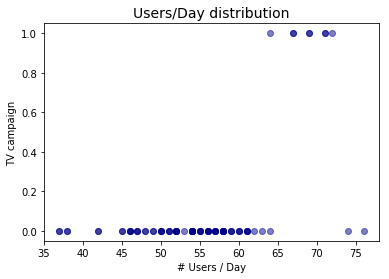

In [16]:
# Check distribution of nr of users between campaign days and no campaign days
plt.plot( 'userid', 'is_tv_campaign', data=df_tv, linestyle='none', marker='o', color = 'darkblue', alpha=.5)
plt.title("Users/Day distribution",fontsize=14)
plt.xlabel('# Users / Day', fontsize=10)
plt.ylabel('TV campaign', fontsize=10);

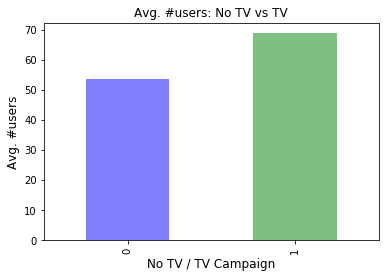

In [17]:
colors = ['blue','green']
label='First Line'
df_new=df_tv.groupby('is_tv_campaign')['userid'].mean()
df_new.plot(kind='bar',title='Avg. #users: No TV vs TV',color=colors, alpha=.5)
plt.xlabel('No TV / TV Campaign', fontsize=12)
plt.ylabel('Avg. #users', fontsize=12);

In [18]:
# Calculate % difference between the average number of users acuired in days with campaign and without campaign
1-df_tv.query('is_tv_campaign=="1"').userid.mean() / df_tv.query('is_tv_campaign=="0"').userid.mean()

-0.2823033707865168

In [19]:
# Add index to the new dataframe
df_tv.reset_index(inplace=True)

In [20]:
# Define variables and fit linear regression model
X = df_tv['is_tv_campaign']
Y = df_tv['userid']
X = sm.add_constant(X)
lm = sm.OLS(Y,X).fit()
lm.summary()

/Users/delia.amarandei/Documents/python/udacity_data_analyst/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 userid   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     37.88
Date:                Wed, 15 May 2019   Prob (F-statistic):           2.11e-08
Time:                        21:20:24   Log-Likelihood:                -300.42
No. Observations:                  91   AIC:                             604.8
Df Residuals:                      89   BIC:                             609.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             53.6145      0.729     73.532      0.000      52.166      55.063
is_tv_campaign    15.1355      2.459      6.155      0.000      10.249      20.022
==============================================================================
Omnibus:                        6.883   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.032   Jarque-Bera (JB):               12.340
Skew:                           0.051   Prob(JB):                      0.00209
Kurtosis:                       4.801   Cond. No.                         3.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the linear regression model we observe that on average, for most of the days with no tv campaigns running we have between 52.166 and 55.063 acquired users, while on days when tv campaigns were running we will have between 10.249 and 20.022 users more. 
With a 28% increase on average we can assume that doubling the tv campaign spending would double also the additional suers acquired, so 15 * 8 = 120 additional signed up users on average, with potential to increase them to a maximum of 20 * 8 = 160 users.

<a id='budget_allocation'></a>
### Part III: Budget allocation

As our data is per distinct user it does not include the sequence of the different channels touchpoint, only which ones were accessed before converting, so singining up in this case. 

From the Multi-Channel Attribution Model we will use the Linear attribution model, where each touchpoint in the conversion path (in this case the cpc, affiliate and social) would share equal credit for the user acquisition, so the costs will be equally distributed for each signed up user, depending on the channels they accessed. I excluded organic channel from the cost distribution as we assume that in this case no SEO company is hired.

For the budget allocation we could calculate this with Markov chains, which is a process which maps the movement and gives a probability distribution, for moving from one channel to another. For this, however, we need to know the order of the channels accessed and we need also to have the negative data, the cases when the users do not signup. So this model can't be applied here.

If we had in the sample also information about users who didn't signed up we could apply logistic regression to model interactions between the channels and this way identify how effective each channel is and therefor split budget according to this.

In [21]:
# Identify most efficient channel combinations
df_new=df.groupby(['cpc','organic','affiliate','social']).count().userid.sort_values(ascending=False)
df_new.head(15)

cpc  organic  affiliate  social
0    0        1          1         2013
                         0          981
1    0        1          0          499
              0          1          494
                         0          255
              1          1          239
0    1        0          1          122
1    1        0          0          117
0    1        1          0          102
                         1           63
              0          0           61
1    1        0          1           54
Name: userid, dtype: int64

<a id='conclusions'></a>
### Conclusions

From the analysis conducted we identified that most users that signed up went through affiliate and social channels.

We identified also that doubling the tv campaign could increase the number of users with up to 20 more per day, so this would definitely be a way to attract more users, however here we would need to consider also other factors such as the campaign costs and the revenue uplift we have after running the campaigns.

From the Multi-Channel Attribution Model we will use the Linear attribution model, where each touchpoint in the conversion path (in this case the cpc, affiliate and social) would share equal credit for the user acquisition, so the costs will be equally distributed for each signed up user, depending on the channels they accessed. I excluded organic channel from the cost distribution as we assume that in this case no SEO company is hired.

Regarding further allocating the budget in order to maximize user acquisition, since we do not have enough data to correctly split it between the channels it would be better to keep it as previously distributed, in order to avoid making a costly mistake.

### Resources
[Multi channel attribution model with R part I](https://towardsdatascience.com/multi-channel-attribution-model-with-r-part-1-markov-chains-concept-fdd964017626)<br><br>
[Multi channel atrribution model with R part II](https://analyzecore.com/2017/05/31/marketing-multi-channel-attribution-model-r-part-2-practical-issues/)<br><br>
[A Beginner’s Guide to Channel Attribution Modeling in Marketing (using Markov Chains, with a case study in R)](https://www.analyticsvidhya.com/blog/2018/01/channel-attribution-modeling-using-markov-chains-in-r/)